Importamos las librerías que se usarán para realizar el ETL y el EDA

In [636]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geojson
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary
from ydata_profiling import ProfileReport as pr
import pandas as pd
import folium
from folium.plugins import HeatMap
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import re
import sketch



## Extracción, transformación y carga ETL

Realizando una pre inspección de los dataset, observamos que se encuentran en formato .xlsx.

El dataset homicidios.xlsx contiene dos tablas con registros: Una con el nombre de "HECHOS" y otra denominada "VICTIMAS" cada una con su diccionario de variables y definiciones. 

Realizamos la carga de los datasets:

In [637]:
ruta_absoluta = r'C:\Users\Coder\Documents\PROYECTO INDIVIDUAL2\data\homicidios.xlsx'

df = pd.ExcelFile(ruta_absoluta)
df_hechos = pd.read_excel(df, 'HECHOS')
df_victimas = pd.read_excel(df, 'VICTIMAS')

### Tratamiento dataset "hechos"

Verificamos la información del dataset:

In [638]:
df_hechos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Direc

Verificamos datos duplicados:

In [639]:
df_hechos.duplicated().sum()

0

Ahora verificamos datos faltantes:

In [640]:
missing_data = df_hechos.isnull().sum()
print(missing_data)


ID                         0
N_VICTIMAS                 0
FECHA                      0
AAAA                       0
MM                         0
DD                         0
HORA                       0
HH                         0
LUGAR_DEL_HECHO            0
TIPO_DE_CALLE              0
Calle                      1
Altura                   567
Cruce                    171
Dirección Normalizada      8
COMUNA                     0
XY (CABA)                  0
pos x                      0
pos y                      0
PARTICIPANTES              0
VICTIMA                    0
ACUSADO                    0
dtype: int64


Observamos que existen datos faltantes en las columnas Calle (1), Altura (567), Cruce (171) y dirección normalizada (8) para un total de 747. 

Se procederá a eliminar la columna altura ya que falta el 81,46% de los registros. Las demás las mantendremos, por ejemplo, dirección normalizada y calle poseen muy pocos faltantes. Con respecto a la columna cruce corresponde a accidentes que han ocurrido en una intersección y por tal razón sólo posee registros que corresponden a ésa característica.

In [641]:
#Eliminamos la columna Altura:
df_hechos.drop("Altura", axis=1, inplace=True)
df_hechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Cruce                  525 non-null    object        
 12  Dirección Normalizada  688 non-null    object        
 13  COMUN

In [642]:
df_hechos.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


Observamos columnas que tienen siglas: AAAA, MM, DD, y HH (La cual corresponde a la franja horaria entera). Procedemos a renombrarlas por "Año", "Mes", "Dia" y "Hora". La Columna "HORA" la definiremos como "Hora completa" para diferenciarla con la de la franja horaria entera:

In [643]:
df_hechos= df_hechos.rename(columns={"AAAA": "Año", "MM":"Mes", "DD": "Día","HORA": "Hora completa"})

In [644]:
df_hechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   Año                    696 non-null    int64         
 4   Mes                    696 non-null    int64         
 5   Día                    696 non-null    int64         
 6   Hora completa          696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Cruce                  525 non-null    object        
 12  Dirección Normalizada  688 non-null    object        
 13  COMUN

In [645]:
df_hechos= df_hechos.rename(columns={"HH": "Hora"})

In [646]:
df_hechos.head()

,ID,N_VICTIMAS,FECHA,Año,Mes,Día,Hora completa,Hora,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


Se observa que los nombres de las columnas se encuentran registradas en una mezcla de minúsculas y mayúsculas. Realizamos la modificación: 

In [647]:
df_hechos.columns = [x.capitalize() for x in df_hechos.columns]

Observamos que algunas columnas poseen espaciado por guiones. Para dejar todo normalizado los reemplazamos por espacios:

In [648]:
df_hechos.columns = df_hechos.columns.str.replace("_", " ")

Verificamos los cambios:

In [649]:
df_hechos.head()

,Id,N victimas,Fecha,Año,Mes,Día,Hora completa,Hora,Lugar del hecho,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,Xy (caba),Pos x,Pos y,Participantes,Victima,Acusado
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


Por último modificamos el tipo de dato de la columna "Hora" a numérico y después a tipo entero:

In [650]:
df_hechos["Hora"] = pd.to_numeric(df_hechos ["Hora"], errors="coerce")
df_hechos["Hora"] = df_hechos["Hora"].astype("Int64")

_____________________________________________________________________________________________________________

### Tratamiento dataset "víctimas"

Ahora verificamos el dataframe df_victimas:

In [651]:
df_victimas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


In [652]:
df_victimas.duplicated().sum()

0

Ahora revisamos si hay datos faltantes: 


In [653]:
missing_data = df_victimas.isnull().sum()
print(missing_data)

ID_hecho               0
FECHA                  0
AAAA                   0
MM                     0
DD                     0
ROL                    0
VICTIMA                0
SEXO                   0
EDAD                   0
FECHA_FALLECIMIENTO    0
dtype: int64


Observamos columnas que tienen siglas: AAAA, MM y DD. Las renombramos para que quede normalizado con el dataframe anterior: "Año", "Mes", "Dia" y "Hora":

In [654]:
df_victimas= df_victimas.rename(columns={"AAAA": "Año", "MM":"Mes", "DD": "Día"})

Modificamos los nombres de las columnas que poseen guión como separador y lo reemplazamos por espacio:

In [655]:
df_victimas.columns = df_victimas.columns.str.replace("_", " ")

Cambiamos los nombres de las columnas a minúscula con la inicial mayúscula:

In [656]:
df_victimas.columns = [x.capitalize() for x in df_victimas.columns]

Verificamos los cambios:

In [657]:
df_victimas.head()

,Id hecho,Fecha,Año,Mes,Día,Rol,Victima,Sexo,Edad,Fecha fallecimiento
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00


Observamos que la columna "Fecha fallecimiento" posee una mezcla de fecha y hora. Sólo nos será útil la fecha por lo cual procederemos a eliminar la parte que indica la hora: 

In [658]:
# Cambiamos las filas con registro SD a espacio vacío:
df_victimas['Fecha fallecimiento'] = df_victimas['Fecha fallecimiento'].replace('SD', '')

In [659]:
# Cambiamos los registros con NaT (Not a Time) con un espacio vacío:
df_victimas['Fecha fallecimiento'] = df_victimas['Fecha fallecimiento'].fillna('')

In [660]:
# Cambiamos el tipo de dato Object a datetime:
df_victimas['Fecha fallecimiento'] = pd.to_datetime(df_victimas['Fecha fallecimiento'])

In [661]:
# Extraemos sólo la parte de la fecha
df_victimas['Fecha fallecimiento'] = df_victimas['Fecha fallecimiento'].dt.date

In [662]:
df_victimas.head()

,Id hecho,Fecha,Año,Mes,Día,Rol,Victima,Sexo,Edad,Fecha fallecimiento
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,NaT
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01


Observamos que algunos registros quedaron como NaT (Not a Time). Los reemplazamos como vacíos para facilitar la manipulación: 

In [663]:
df_victimas['Fecha fallecimiento'] = df_victimas['Fecha fallecimiento'].fillna('')


Cambiamos el nombre de la columna "ID hecho" por "Id":

In [664]:
df_victimas=df_victimas.rename(columns={'Id hecho':'Id'})

Cambiamos la columna "Edad" a tipo entero:

In [665]:
df_victimas ["Edad"] = pd.to_numeric(df_victimas["Edad"], errors="coerce")
df_victimas ["Edad"] = df_victimas["Edad"].astype("Int64")

__________________________________________________________________________________________________________________

### Combinación de los dataframes

Realizamos la combinación de los dataframes usando la funcion merge y la columna "Id":

In [666]:
df = df_hechos.merge(df_victimas, on='Id', how='inner')

In [667]:
df.head()

,Id,N victimas,Fecha_x,Año_x,Mes_x,Día_x,Hora completa,Hora,Lugar del hecho,Tipo de calle,...,Acusado,Fecha_y,Año_y,Mes_y,Día_y,Rol,Victima_y,Sexo,Edad,Fecha fallecimiento
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,AUTO,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,PASAJEROS,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,AUTO,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,SD,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,PASAJEROS,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01


Observamos que hay columnas que posiblemente tengan registros iguales. Verificamos y eliminamos:

In [668]:
def encontrar_columnas_iguales(df):
    columnas_iguales = []

    n_columnas = len(df.columns)

    for i in range(n_columnas):
        for j in range(i + 1, n_columnas):
            if df.iloc[:, i].equals(df.iloc[:, j]):
                columnas_iguales.append((df.columns[i], df.columns[j]))
                
    return columnas_iguales

columnas_iguales = encontrar_columnas_iguales(df)

print("Pares de columnas iguales:")
for columna1, columna2 in columnas_iguales:
    print(f"{columna1} y {columna2} son iguales")

Pares de columnas iguales:
Año_x y Año_y son iguales
Mes_x y Mes_y son iguales


Eliminamos las columnas Año_y y Mes_y:

In [669]:
df = df.drop(['Año_y','Mes_y'],axis=1)

In [670]:
df.head()

,Id,N victimas,Fecha_x,Año_x,Mes_x,Día_x,Hora completa,Hora,Lugar del hecho,Tipo de calle,...,Participantes,Victima_x,Acusado,Fecha_y,Día_y,Rol,Victima_y,Sexo,Edad,Fecha fallecimiento
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,MOTO-AUTO,MOTO,AUTO,2016-01-01,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,AUTO-PASAJEROS,AUTO,PASAJEROS,2016-01-02,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,MOTO-AUTO,MOTO,AUTO,2016-01-03,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,MOTO-SD,MOTO,SD,2016-01-10,10,CONDUCTOR,MOTO,MASCULINO,18,
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,MOTO-PASAJEROS,MOTO,PASAJEROS,2016-01-21,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01


Observamos que en el merge también se crearon nuevas columnas para Fecha, Día y Victima. Verificamos porqué no son iguales:

In [671]:
#Creamos una lista vacía para almacenar los índices de las filas donde de hallen diferencias
diferencias=[]

# Se itera sobre cada fila del DataFrame, solo en las columnas especificadas:
for index, row  in df[['Fecha_x','Fecha_y', 'Día_x','Día_y', 'Victima_x',  'Victima_y']].iterrows():

    if row['Fecha_x'] !=row['Fecha_y']:
        diferencias.append(index)

    if row['Día_x'] !=row['Día_y']:
        diferencias.append(index)
    if row['Victima_x'] !=row['Victima_y']:
        diferencias.append(index)
        
diferencias

[65, 204, 204, 237, 238, 602, 603]

Verificamos el contenido completo de las filas de los indices con diferencias:

In [672]:
df[['Fecha_x','Fecha_y', 'Día_x','Día_y', 'Victima_x', 'Victima_y','Fecha fallecimiento','Acusado']].iloc[diferencias]

,Fecha_x,Fecha_y,Día_x,Día_y,Victima_x,Victima_y,Fecha fallecimiento,Acusado
65,2016-07-02,2016-07-03,3,3,MOTO,MOTO,2016-07-03,OBJETO FIJO
204,2017-05-24,2017-05-29,24,29,MOTO,MOTO,2017-05-29,SD
204,2017-05-24,2017-05-29,24,29,MOTO,MOTO,2017-05-29,SD
237,2017-09-02,2017-09-02,2,2,OBJETO FIJO,AUTO,2017-09-02,AUTO
238,2017-09-02,2017-09-02,2,2,OBJETO FIJO,AUTO,2017-09-02,AUTO
602,2020-12-05,2020-12-05,5,5,PEATON_MOTO,PEATON,2020-12-05,MOTO
603,2020-12-05,2020-12-05,5,5,PEATON_MOTO,MOTO,2020-12-05,MOTO


Observamos que las columnas fechas poseen diferencias y no nos es posible discernir cuál posee los registros verdaderos. Eliminaremos cualquiera de los dos, por ejemplo Fecha_y y Día_y.  Con respecto a las columnas Victima, observamos que en Victima_y hay registros con nombre "Objeto fijo" pero en la columna Victima_x ésa misma fila está con el nombre "AUTO", Por lo cual establecemos que los registros de ésta última están bien y eliminamos la columna Victima_x:  

In [673]:

df = df.drop(['Día_y','Fecha_y', 'Victima_x'],axis=1)

In [674]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     717 non-null    object        
 1   N victimas             717 non-null    int64         
 2   Fecha_x                717 non-null    datetime64[ns]
 3   Año_x                  717 non-null    int64         
 4   Mes_x                  717 non-null    int64         
 5   Día_x                  717 non-null    int64         
 6   Hora completa          717 non-null    object        
 7   Hora                   716 non-null    Int64         
 8   Lugar del hecho        717 non-null    object        
 9   Tipo de calle          717 non-null    object        
 10  Calle                  716 non-null    object        
 11  Cruce                  540 non-null    object        
 12  Dirección normalizada  708 non-null    object        
 13  Comun

Renombramos las columnas Fecha_x, Año_x, Mes_x, Día_x y Victima_y  

In [675]:
df= df.rename(columns={"Fecha_x": "Fecha", "Año_x":"Año", "Mes_x": "Mes","Día_x": "Día", "Victima_y": "Victima"})

Revisamos si se efectuaron los cambios:

In [676]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     717 non-null    object        
 1   N victimas             717 non-null    int64         
 2   Fecha                  717 non-null    datetime64[ns]
 3   Año                    717 non-null    int64         
 4   Mes                    717 non-null    int64         
 5   Día                    717 non-null    int64         
 6   Hora completa          717 non-null    object        
 7   Hora                   716 non-null    Int64         
 8   Lugar del hecho        717 non-null    object        
 9   Tipo de calle          717 non-null    object        
 10  Calle                  716 non-null    object        
 11  Cruce                  540 non-null    object        
 12  Dirección normalizada  708 non-null    object        
 13  Comun

Extraemos las coordenadas de la columna Xy(caba) para usarlas posteriormente

In [677]:
def extraer_coordenadas(texto):
    # Definimos la variable para extraer las coordenadas
    coordenadas = re.findall(r'\d+\.\d+', texto)
    if len(coordenadas) == 2:
        return float(coordenadas[0]), float(coordenadas[1])
    else:
        return None, None

# Se aplica la función a la columna 'Xy (Caba)'
df['coordenada_x'], df['coordenada_y'] = zip(*df['Xy (caba)'].map(extraer_coordenadas))

# Se filtran los registros que no tienen coordenadas válidas
df = df[(df['coordenada_x'].notnull()) & (df['coordenada_y'].notnull())]

In [678]:
df.head()

,Id,N victimas,Fecha,Año,Mes,Día,Hora completa,Hora,Lugar del hecho,Tipo de calle,...,Pos y,Participantes,Acusado,Rol,Victima,Sexo,Edad,Fecha fallecimiento,coordenada_x,coordenada_y
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,-34.68757022,MOTO-AUTO,AUTO,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01,98896.782384,93532.434378
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,-34.66977709,AUTO-PASAJEROS,PASAJEROS,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02,95832.055711,95505.416420
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,-34.63189362,MOTO-AUTO,AUTO,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03,106684.290900,99706.576878
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,-34.68092974,MOTO-SD,SD,CONDUCTOR,MOTO,MASCULINO,18,,99840.652248,94269.165344
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,-34.62246630,MOTO-PASAJEROS,PASAJEROS,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01,106980.328279,100752.169158


In [698]:
df.to_csv('merge.csv', index=False)

___________________________________________________________________________________________________________

### EDA

Verificación de Outliers:

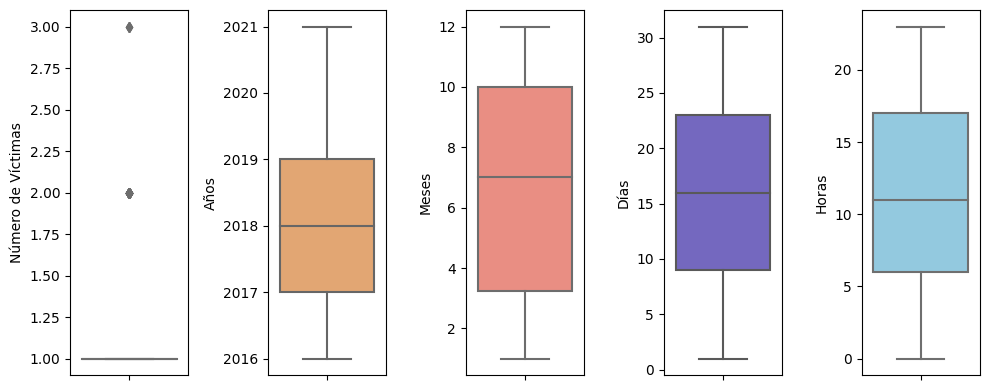

In [679]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 4))

# Crear subplots para los gráficos 
plt.subplot(1, 5, 1) 
sns.boxplot(data=df, y='N victimas', color = "#FA8072")
plt.ylabel('Número de Víctimas')

plt.subplot(1, 5, 2) 
sns.boxplot(data=df, y='Año', color = "#F4A460")
plt.ylabel('Años')

plt.subplot(1, 5, 3) 
sns.boxplot(data=df, y='Mes', color = "#FA8072")
plt.ylabel('Meses')

plt.subplot(1, 5, 4) 
sns.boxplot(data=df, y='Día', color = "#6A5ACD")
plt.ylabel('Días')

plt.subplot(1, 5, 5) 
sns.boxplot(data=df, y='Hora', color = "#87CEEB")
plt.ylabel('Horas')

# Ajustar espaciado entre subplots
plt.tight_layout()

plt.show()

Los outliers con respecto al número de victimas es debido a que en la mayoría de los siniestros, la cantidad de victimas es de valor uno y en ésos casos puntuales, la cantidad e victimas fueron de 2 y 3. 

### Relación del número de victimas con respecto al tiempo:

Creamos una columna llamda Semestre para realizar el cálculo del KPI:

In [680]:
# Extraer el mes de la fecha y calcular el semestre
df['Semestre'] = (df['Fecha'].dt.month - 1) // 6 + 1

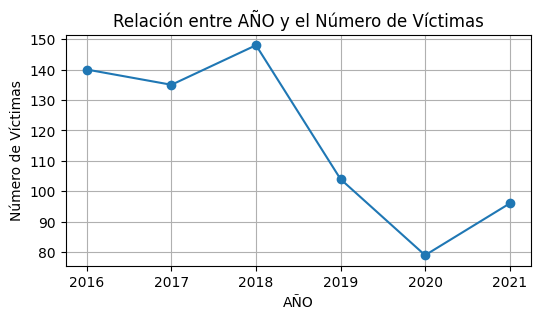

In [681]:
# Agrupamos los datos por fecha y suma el número de víctimas en cada fecha
victimas_por_fecha = df.groupby('Año')['N victimas'].count().reset_index()

# Crea la gráfica
plt.figure(figsize=(6, 3))  # Ajusta el tamaño de la gráfica según tus preferencias
plt.plot(victimas_por_fecha['Año'], victimas_por_fecha['N victimas'], marker='o', linestyle='-')
plt.title('Relación entre AÑO y el Número de Víctimas')
plt.xlabel('AÑO')
plt.ylabel('Número de Víctimas')
plt.grid(True)

# Mostrar la gráfica
plt.show()



Se observa que durante los años 2017 y 2018 se produjeron la mayor cantidad de victimas fatales. Asi mismo, después del 2018 hubo una pronunciada disminución de los siniestros llegando al punto más bajo en el año 2020, que seguramente fue debido al confinamiento que pordujo la pandemia del Covid19.

Posteriormente hubo un aumento en el 2021 aunque inferior a l registrado en el 2019.

### Relación entre la Edad de las víctimas y la cantidad de siniestros viales

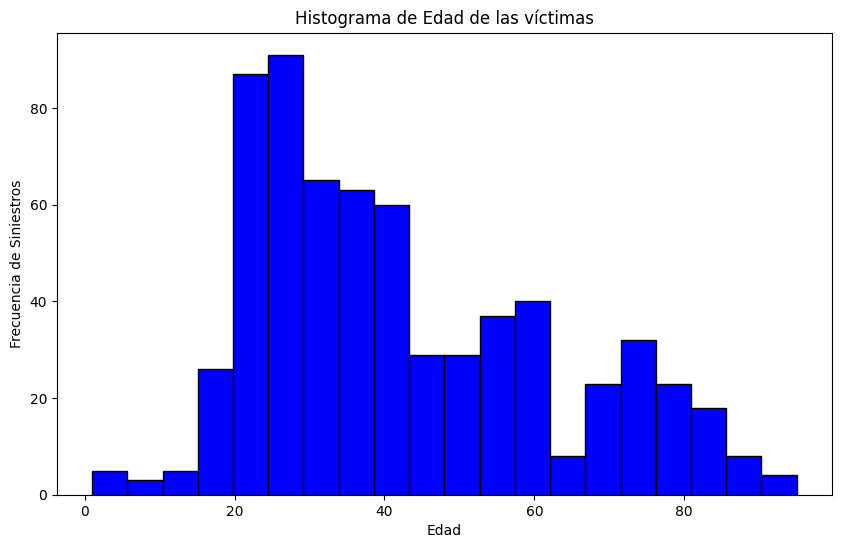

In [697]:
df['Edad'].plot.hist(bins=20, edgecolor='black', color='blue', figsize=(10, 6))
plt.title('Histograma de Edad de las víctimas')
plt.xlabel('Edad')
plt.ylabel('Frecuencia de Siniestros')

plt.show()

In [ ]:
df["Edad"].describe()

count        656.0
mean     42.297256
std      19.843781
min            1.0
25%           27.0
50%           37.0
75%           57.0
max           95.0
Name: Edad, dtype: Float64

Con ayuda del histograma anterior podemos concluir que el 75% de las víctimas fatales es menor que 57 años. La mediana se sitúa en los 42 años. También podemos concluir que la mayor cantiad de víctimas fatales se concentra entre los 20 a 40 años de edad.

### Distribución etaria según el Sexo

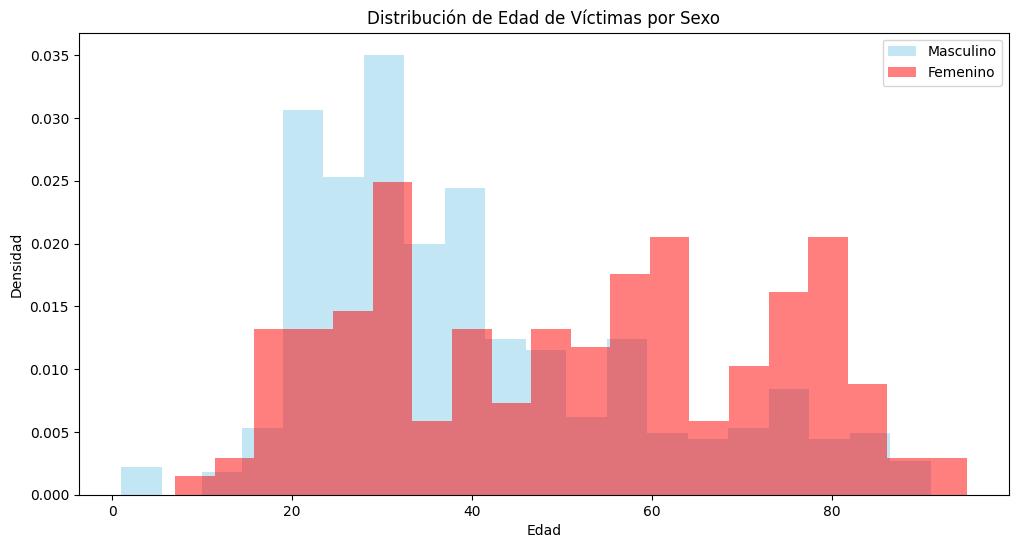

In [689]:
masculino = df[df['Sexo'] == 'MASCULINO']['Edad'].dropna()

# Filtrar por sexo femenino
femenino = df[df['Sexo'] == 'FEMENINO']['Edad'].dropna()

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.hist(masculino, bins=20, alpha=0.5, color='skyblue', label='Masculino', density=True)
plt.hist(femenino, bins=20, alpha=0.5, color='red', label='Femenino', density=True)
plt.title('Distribución de Edad de Víctimas por Sexo')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend()
plt.show()

Con ayuda el histograma podemos observar que las victimas de sexo femenino poseen unos picos en las edades de 30, 60 y 80 años. 

Con respecto a los hombres, en contraste observamos que la mayoría de las víctimas están concentradas entre los 20 y 40 años de edad.

### Distribución de siniestros por comunas

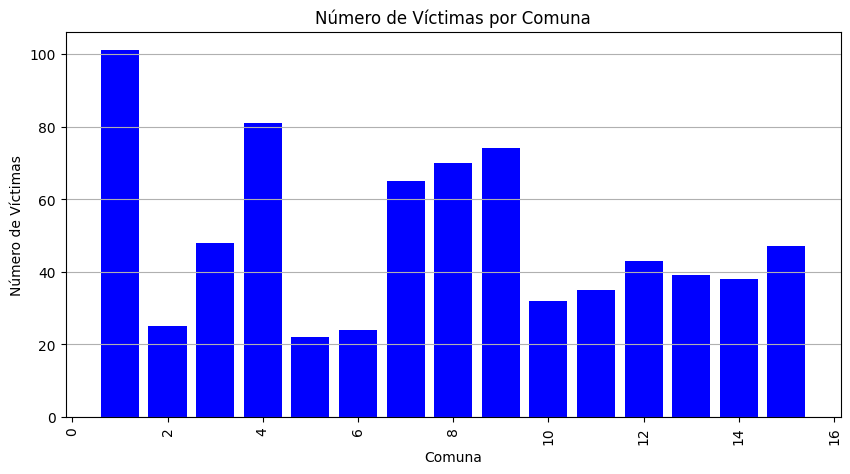

In [691]:
victimas_comuna = df.groupby('Comuna')['N victimas'].sum().reset_index()

# Crea la gráfica de barras
plt.figure(figsize=(10, 5))
plt.bar(victimas_comuna['Comuna'], victimas_comuna['N victimas'], color='blue')  # Puedes cambiar el color según tus preferencias
plt.title('Número de Víctimas por Comuna')
plt.xlabel('Comuna')
plt.ylabel('Número de Víctimas')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para una mejor visualización
plt.grid(axis='y')

# Mostrar la gráfica
plt.show()

Observamos que la distribución de las víctimas por comuna es bastante heterogénea. Sería necesario verificar más al detalle las comunas 1, 4, 7, 8 y 9 las cuales presentan los mayores registros de siniestros. Valdría la pena verificar si existe alguna zona de alta densidad vehicular que pueda influir en la accidentalidad.

### Distribucíon de víctimas según género y tipo de vehículo

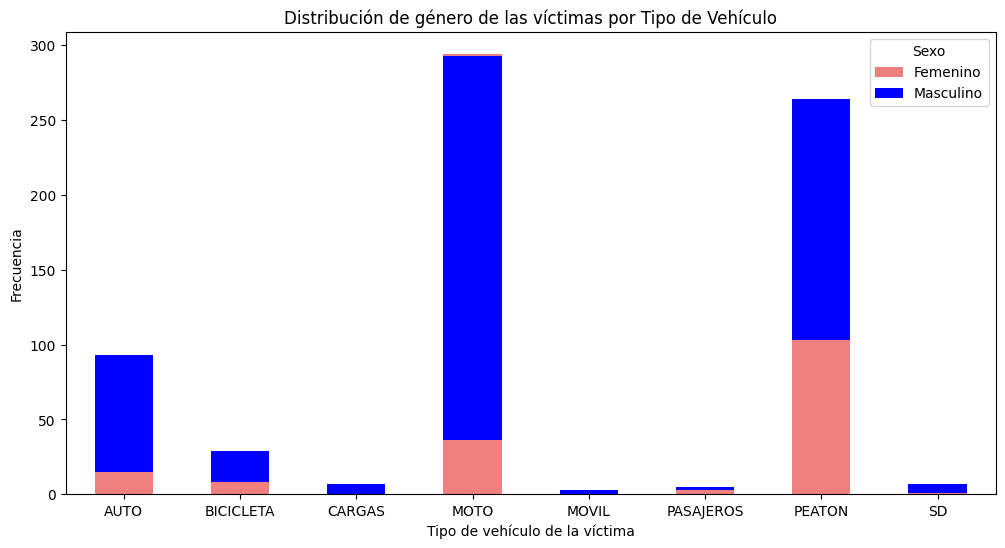

In [696]:
tabla_contingencia = pd.crosstab(df['Victima'], df['Sexo'])


ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(12, 6), color=["lightcoral",'blue'])
plt.title('Distribución de género de las víctimas por Tipo de Vehículo')
plt.xlabel('Tipo de vehículo de la víctima')
plt.ylabel('Frecuencia')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Femenino', 'Masculino'], title='Sexo')

plt.xticks(rotation=0)
plt.show()

Observamos que para ambos sexos, la mayoría de victimas viajaban en moto o eran peatones. La cantidad de victimas hombres es notoriamente mayor al de las mujeres.

